https://keras.io/examples/nlp/multi_label_classification/

In [20]:
from tensorflow.keras import layers
from tensorflow import keras
import tensorflow as tf

from sklearn.model_selection import train_test_split
from ast import literal_eval

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

In [21]:
arxiv_data = pd.read_csv(
    "https://github.com/soumik12345/multi-label-text-classification/releases/download/v0.2/arxiv_data.csv"
)
arxiv_data.head()

,titles,summaries,terms
0,Survey on Semantic Stereo Matching / Semantic ...,Stereo matching is one of the widely used tech...,"['cs.CV', 'cs.LG']"
1,FUTURE-AI: Guiding Principles and Consensus Re...,The recent advancements in artificial intellig...,"['cs.CV', 'cs.AI', 'cs.LG']"
2,Enforcing Mutual Consistency of Hard Regions f...,"In this paper, we proposed a novel mutual cons...","['cs.CV', 'cs.AI']"
3,Parameter Decoupling Strategy for Semi-supervi...,Consistency training has proven to be an advan...,['cs.CV']
4,Background-Foreground Segmentation for Interio...,"To ensure safety in automated driving, the cor...","['cs.CV', 'cs.LG']"


In [22]:
print(f"There are {len(arxiv_data)} rows in the dataset.")
total_duplicate_titles = sum(arxiv_data["titles"].duplicated())
print(f"There are {total_duplicate_titles} duplicate titles.")

There are 51774 rows in the dataset.
There are 12802 duplicate titles.


In [23]:
arxiv_data = arxiv_data[~arxiv_data["titles"].duplicated()]
print(f"There are {len(arxiv_data)} rows in the deduplicated dataset.")

# There are some terms with occurrence as low as 1.
print(sum(arxiv_data["terms"].value_counts() == 1))

# How many unique terms?
print(arxiv_data["terms"].nunique())

There are 38972 rows in the deduplicated dataset.
2321
3157


In [24]:
# Filtering the rare terms.
arxiv_data_filtered = arxiv_data.groupby("terms").filter(lambda x: len(x) > 1)
arxiv_data_filtered.shape

(36651, 3)

In [25]:
arxiv_data_filtered["terms"] = arxiv_data_filtered["terms"].apply(
    lambda x: literal_eval(x)
)
arxiv_data_filtered["terms"].values[:5]

array([list(['cs.CV', 'cs.LG']), list(['cs.CV', 'cs.AI', 'cs.LG']),
       list(['cs.CV', 'cs.AI']), list(['cs.CV']),
       list(['cs.CV', 'cs.LG'])], dtype=object)

In [26]:
test_split = 0.1

# Initial train and test split.
train_df, test_df = train_test_split(
    arxiv_data_filtered,
    test_size=test_split,
    stratify=arxiv_data_filtered["terms"].values,
)

# Splitting the test set further into validation
# and new test sets.
val_df = test_df.sample(frac=0.5)
test_df.drop(val_df.index, inplace=True)

print(f"Number of rows in training set: {len(train_df)}")
print(f"Number of rows in validation set: {len(val_df)}")
print(f"Number of rows in test set: {len(test_df)}")

Number of rows in training set: 32985
Number of rows in validation set: 1833
Number of rows in test set: 1833


In [27]:
terms = tf.ragged.constant(train_df["terms"].values)
lookup = tf.keras.layers.StringLookup(output_mode="multi_hot")
lookup.adapt(terms)
vocab = lookup.get_vocabulary()


def invert_multi_hot(encoded_labels):
    """Reverse a single multi-hot encoded label to a tuple of vocab terms."""
    hot_indices = np.argwhere(encoded_labels == 1.0)[..., 0]
    return np.take(vocab, hot_indices)


print("Vocabulary:\n")
print(vocab)

Vocabulary:

['[UNK]', 'cs.CV', 'cs.LG', 'stat.ML', 'cs.AI', 'eess.IV', 'cs.RO', 'cs.CL', 'cs.NE', 'cs.CR', 'math.OC', 'eess.SP', 'cs.GR', 'cs.SI', 'cs.MM', 'cs.SY', 'cs.IR', 'cs.MA', 'eess.SY', 'cs.HC', 'math.IT', 'cs.IT', 'cs.DC', 'cs.CY', 'stat.AP', 'stat.TH', 'math.ST', 'stat.ME', 'eess.AS', 'cs.SD', 'q-bio.QM', 'q-bio.NC', 'cs.DS', 'cs.GT', 'cs.CG', 'cs.NI', 'cs.SE', 'I.2.6', 'stat.CO', 'math.NA', 'cs.NA', 'physics.chem-ph', 'cs.DB', 'q-bio.BM', 'cs.LO', 'cond-mat.dis-nn', '68T45', 'math.PR', 'cs.PL', 'physics.comp-ph', 'cs.CE', 'cs.AR', 'I.2.10', 'q-fin.ST', 'cond-mat.stat-mech', 'math.DS', '68T05', 'quant-ph', 'cs.CC', 'I.4.6', 'physics.data-an', 'physics.ao-ph', 'physics.soc-ph', 'cs.DM', 'econ.EM', 'q-bio.GN', 'physics.med-ph', 'astro-ph.IM', 'I.4.8', 'math.AT', 'cs.PF', 'I.4', 'q-fin.TR', 'cs.FL', 'I.5.4', 'I.2', '68U10', 'physics.geo-ph', 'hep-ex', '68T10', 'physics.optics', 'cond-mat.mtrl-sci', 'q-fin.CP', 'physics.flu-dyn', 'math.AP', 'I.4; I.5', 'I.4.9', 'I.2.6; I.2.8', '

In [28]:
sample_label = train_df["terms"].iloc[0]
print(f"Original label: {sample_label}")

label_binarized = lookup([sample_label])
print(f"Label-binarized representation: {label_binarized}")

Original label: ['cs.CV', 'q-bio.QM']
Label-binarized representation: [[0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0]]


In [29]:
train_df["summaries"].apply(lambda x: len(x.split(" "))).describe()

count    32985.000000
mean       156.528937
std         41.458429
min          5.000000
25%        128.000000
50%        155.000000
75%        183.000000
max        462.000000
Name: summaries, dtype: float64

In [30]:
max_seqlen = 150
batch_size = 128
padding_token = "<pad>"
auto = tf.data.AUTOTUNE


def make_dataset(dataframe, is_train=True):
    labels = tf.ragged.constant(dataframe["terms"].values)
    label_binarized = lookup(labels).numpy()
    dataset = tf.data.Dataset.from_tensor_slices(
        (dataframe["summaries"].values, label_binarized)
    )
    dataset = dataset.shuffle(batch_size * 10) if is_train else dataset
    return dataset.batch(batch_size)

In [31]:
train_dataset = make_dataset(train_df, is_train=True)
validation_dataset = make_dataset(val_df, is_train=False)
test_dataset = make_dataset(test_df, is_train=False)

In [32]:
text_batch, label_batch = next(iter(train_dataset))

for i, text in enumerate(text_batch[:5]):
    label = label_batch[i].numpy()[None, ...]
    print(f"Abstract: {text}")
    print(f"Label(s): {invert_multi_hot(label[0])}")
    print(" ")

Abstract: b'Deep neural networks have been successfully applied to problems such as image\nsegmentation, image super-resolution, coloration and image inpainting. In this\nwork we propose the use of convolutional neural networks (CNN) for image\ninpainting of large regions in high-resolution textures. Due to limited\ncomputational resources processing high-resolution images with neural networks\nis still an open problem. Existing methods separate inpainting of global\nstructure and the transfer of details, which leads to blurry results and loss\nof global coherence in the detail transfer step. Based on advances in texture\nsynthesis using CNNs we propose patch-based image inpainting by a CNN that is\nable to optimize for global as well as detail texture statistics. Our method is\ncapable of filling large inpainting regions, oftentimes exceeding the quality\nof comparable methods for high-resolution images. For reference patch look-up\nwe propose to use the same summary statistics that a

In [33]:
# Source: https://stackoverflow.com/a/18937309/7636462
vocabulary = set()
train_df["summaries"].str.lower().str.split().apply(vocabulary.update)
vocabulary_size = len(vocabulary)
print(vocabulary_size)

153148


In [34]:
print(f'Vocabulary size: {vocabulary_size}')
print(f'Number of unique labels: {len(vocab)}')
print(f'auto: {auto}')

text_vectorizer = layers.TextVectorization(
    max_tokens=vocabulary_size, ngrams=2, output_mode="tf_idf"
)

# `TextVectorization` layer needs to be adapted as per the vocabulary from our
# training set.
with tf.device("/CPU:0"):
    text_vectorizer.adapt(train_dataset.map(lambda text, label: text))

train_dataset = train_dataset.map(
    lambda text, label: (text_vectorizer(text), label), num_parallel_calls=auto
).prefetch(auto)
validation_dataset = validation_dataset.map(
    lambda text, label: (text_vectorizer(text), label), num_parallel_calls=auto
).prefetch(auto)
test_dataset = test_dataset.map(
    lambda text, label: (text_vectorizer(text), label), num_parallel_calls=auto
).prefetch(auto)

Vocabulary size: 153148
Number of unique labels: 153
auto: -1


2024-06-04 13:56:01.263391: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [35]:
def make_model():
    shallow_mlp_model = keras.Sequential(
        [
            layers.Dense(512, activation="relu"),
            layers.Dense(256, activation="relu"),
            layers.Dense(lookup.vocabulary_size(), activation="sigmoid"),
        ]  # More on why "sigmoid" has been used here in a moment.
    )
    return shallow_mlp_model

Epoch 1/20
258/258 ━━━━━━━━━━━━━━━━━━━━ 51s 173ms/step - binary_accuracy: 0.9653 - loss: 0.0818 - val_binary_accuracy: 0.9942 - val_loss: 0.0191
Epoch 2/20
258/258 ━━━━━━━━━━━━━━━━━━━━ 44s 169ms/step - binary_accuracy: 0.9984 - loss: 0.0053 - val_binary_accuracy: 0.9938 - val_loss: 0.0263
Epoch 3/20
258/258 ━━━━━━━━━━━━━━━━━━━━ 44s 160ms/step - binary_accuracy: 0.9998 - loss: 9.7473e-04 - val_binary_accuracy: 0.9938 - val_loss: 0.0340
Epoch 4/20
258/258 ━━━━━━━━━━━━━━━━━━━━ 45s 171ms/step - binary_accuracy: 1.0000 - loss: 3.7449e-04 - val_binary_accuracy: 0.9939 - val_loss: 0.0389
Epoch 5/20
258/258 ━━━━━━━━━━━━━━━━━━━━ 45s 170ms/step - binary_accuracy: 1.0000 - loss: 2.2800e-04 - val_binary_accuracy: 0.9939 - val_loss: 0.0405
Epoch 6/20
258/258 ━━━━━━━━━━━━━━━━━━━━ 46s 176ms/step - binary_accuracy: 1.0000 - loss: 1.4739e-04 - val_binary_accuracy: 0.9939 - val_loss: 0.0412
Epoch 7/20
258/258 ━━━━━━━━━━━━━━━━━━━━ 41s 157ms/step - binary_accuracy: 1.0000 - loss: 1.3940e-04 - val_binary_a

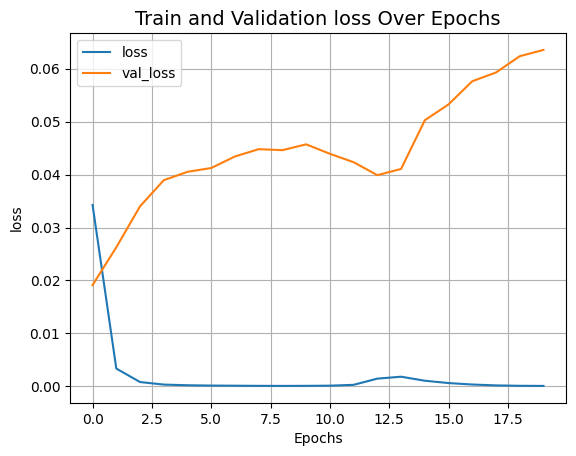

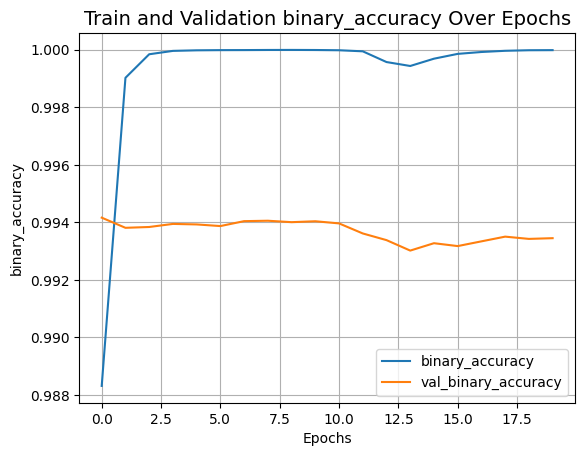

In [36]:
epochs = 20

shallow_mlp_model = make_model()
shallow_mlp_model.compile(
    loss="binary_crossentropy", optimizer="adam", metrics=["binary_accuracy"]
)

history = shallow_mlp_model.fit(
    train_dataset, validation_data=validation_dataset, epochs=epochs
)


def plot_result(item):
    plt.plot(history.history[item], label=item)
    plt.plot(history.history["val_" + item], label="val_" + item)
    plt.xlabel("Epochs")
    plt.ylabel(item)
    plt.title("Train and Validation {} Over Epochs".format(item), fontsize=14)
    plt.legend()
    plt.grid()
    plt.show()


plot_result("loss")
plot_result("binary_accuracy")

In [37]:
_, binary_acc = shallow_mlp_model.evaluate(test_dataset)
print(f"Categorical accuracy on the test set: {round(binary_acc * 100, 2)}%.")

15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - binary_accuracy: 0.9937 - loss: 0.0582
Categorical accuracy on the test set: 99.37%.


In [38]:
# Create a model for inference.
model_for_inference = keras.Sequential([text_vectorizer, shallow_mlp_model])

# Create a small dataset just for demoing inference.
inference_dataset = make_dataset(test_df.sample(100), is_train=False)
text_batch, label_batch = next(iter(inference_dataset))
predicted_probabilities = model_for_inference.predict(text_batch)

# Perform inference.
for i, text in enumerate(text_batch[:5]):
    label = label_batch[i].numpy()[None, ...]
    print(f"Abstract: {text}")
    print(f"Label(s): {invert_multi_hot(label[0])}")
    predicted_proba = [proba for proba in predicted_probabilities[i]]
    top_3_labels = [
        x
        for _, x in sorted(
            zip(predicted_probabilities[i], lookup.get_vocabulary()),
            key=lambda pair: pair[0],
            reverse=True,
        )
    ][:3]
    print(f"Predicted Label(s): ({', '.join([label for label in top_3_labels])})")
    print(" ")

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Abstract: b'With deep learning becoming a more prominent approach for automatic\nclassification of three-dimensional point cloud data, a key bottleneck is the\namount of high quality training data, especially when compared to that\navailable for two-dimensional images. One potential solution is the use of\nsynthetic data for pre-training networks, however the ability for models to\ngeneralise from synthetic data to real world data has been poorly studied for\npoint clouds. Despite this, a huge wealth of 3D virtual environments exist\nwhich, if proved effective can be exploited. We therefore argue that research\nin this domain would be of significant use. In this paper we present SynthCity\nan open dataset to help aid research. SynthCity is a 367.9M point synthetic\nfull colour Mobile Laser Scanning point cloud. Every point is assigned a label\nfrom one of nine categories. We generate our point cloud in a typical\nUrban/Suburban environment using th